In [2]:
import logging
import config

from IPython import display
from dataset.TPL import *
import dataset.preprocessing as pre

import numpy as np
import pandas as pd
import time
import pickle
import ftn
# from pprint import pprint
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline
%reload_ext autoreload
%autoreload 2
logging.basicConfig(level=logging.INFO)

### LDA SKL MODEL- Pionier

#### 1) Import Data:

In [3]:
#---------------------------#
#Importamos la data:
pionier1=TplPionier(config=config.ds_medium)
# Some rows are small (<5 sec) or unbounded (>30m), this criteria will restrict to only the good ones
pionier1.index = pionier1.index[pionier1.index["SECONDS"] > 5]
pionier1.index = pionier1.index[pionier1.index["SECONDS"] < 1800]

#### 2) Data Preprocessing:

In [4]:
%%time
#---------------------------#
#Aplicamos la función:
pionier_SES=ftn.generate_serie_SES(pionier1)

CPU times: total: 1min 56s
Wall time: 2min 11s


In [5]:
#result=open("pionier_SES","wb")
#pickle.dump(pionier_SES,result)
#result.close()

In [25]:
#---------------------------------------#
#First load ()
pionier_SES=pickle.load(open("pionier_SES","rb"))

In [6]:
#Separamos la train_data de la test_data
#----------------------------#
pionier_train,pionier_test=ftn.traintestdata(pionier_SES,0.2)

In [7]:
#Creamos la matriz toke-frequency para nuestra data de entrenamiento:
#----------------------------------------#
info_train_v, v= ftn.vectorizer(pionier_train)
print('Numéro de traces: ',info_train_v.shape[0])
print('Número de tokens: ',info_train_v.shape[1])
#Show vocab v: class countvectorizer()
#v.vocabulary_
#Show vocab in alphabetical order
#v.get_feature_names()

Numéro de traces:  1641
Número de tokens:  27134


**3) LDA optimal model:**

In [8]:
%%time
# Define Search Param
search_params = {'n_components': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda_opt = LatentDirichletAllocation(max_iter=10)

# Init Grid Search Class
model = GridSearchCV(lda_opt, param_grid=search_params)

# Do the Grid Search
model.fit(info_train_v)

CPU times: total: 22min 27s
Wall time: 22min 45s


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15]})

In [9]:
#Best model
bestldamodel = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", bestldamodel.perplexity(info_train_v))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -418250.9252269324
Model Perplexity:  387.34673260959744


In [9]:
#result=open("pionier_optimodel","wb")
#pickle.dump(bestldamodel,result)
#result.close()

In [28]:
#---------------------------------------#
#Second load ()
bestldamodel=pickle.load(open("pionier_optimodel","rb"))

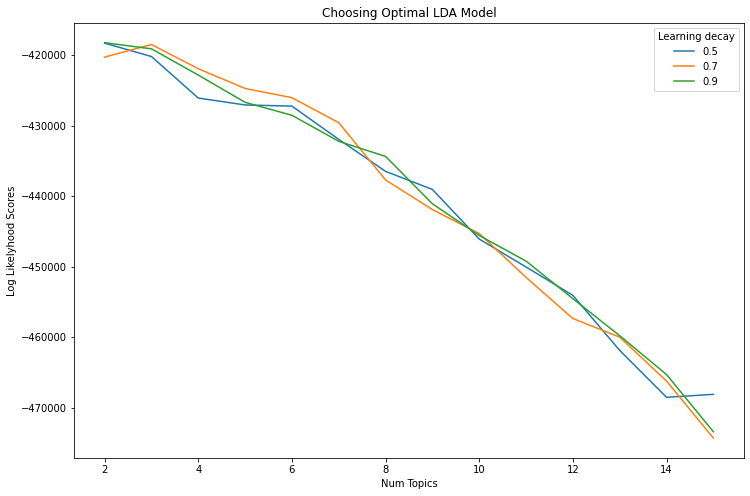

In [13]:
# Get Log Likelyhoods from Grid Search Output
log_likelyhoods_5 = []
log_likelyhoods_7 = []
log_likelyhoods_9 = []
n_topics=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for i in range(len(model.cv_results_['params'])):
    if model.cv_results_['params'][i]['learning_decay'] == 0.5:
       log_likelyhoods_5.append(round(model.cv_results_['mean_test_score'][i]))
    elif model.cv_results_['params'][i]['learning_decay'] == 0.7:
       log_likelyhoods_7.append(round(model.cv_results_['mean_test_score'][i]))
    elif model.cv_results_['params'][i]['learning_decay'] == 0.9:
       log_likelyhoods_9.append(round(model.cv_results_['mean_test_score'][i]))

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [14]:
#Verificamos que todo esté en orden:

#le entregamos nuestra matriz token-frequency creada anteriormente
bestldamodel.fit(info_train_v)

# making LDA TOP MATRIX USING CORPUS TF
lda_topic_modelling = bestldamodel.fit_transform(info_train_v)

In [15]:
#------------------------------------------------#
#Dejamos todo como str (la info contiene números)
pionier_SES=pionier_SES.apply(str)

#Aplicamos el CV
pionier_SES_v = v.transform(pionier_SES)

In [16]:
#----------------------------------------------------#
#Mostramos la contribución de los tópicos a cada una de las traces:
df_topic_dc=ftn.topic_document(bestldamodel,pionier_SES_v)
df_topic_dc

,0,1
0,0.003595,0.996405
1,0.998528,0.001472
2,0.998146,0.001854
3,0.994563,0.005437
4,0.003892,0.996108
...,...,...
2047,0.988934,0.011066
2048,0.015664,0.984336
2049,0.984449,0.015551
2050,0.009601,0.990399


### 4) Results:

In [17]:
#--------------------------------------------------------#
final_df=ftn.final_result(pionier1.index,bestldamodel,pionier_SES_v)
final_df[:30]

,Num trace,START,END,TIMEOUT,system,procname,TPL_ID,ERROR,Aborted,estimated (s),real (s),diff (s),SECONDS,0,1
0,0,2020-12-01 06:58:21.518000+00:00,2020-12-01 07:01:26.742000+00:00,False,PIONIER,bob_ins,PIONIER_gen_tec_scan,True,False,5,2,3,185.0,0.003595,0.996405
1,4,2020-12-01 07:10:51.269000+00:00,2020-12-01 07:20:26.003000+00:00,False,PIONIER,bob_ins,PIONIER_obs_calibrator,False,False,308,935,387,574.0,0.998528,0.001472
2,5,2020-12-01 07:20:26.022000+00:00,2020-12-01 07:24:22.424000+00:00,False,PIONIER,bob_ins,PIONIER_gen_cal_kappa,False,False,125,356,151,236.0,0.998146,0.001854
3,6,2020-12-01 07:24:22.441000+00:00,2020-12-01 07:26:17.805000+00:00,False,PIONIER,bob_ins,PIONIER_gen_cal_dark,False,False,46,155,69,115.0,0.994563,0.005437
4,7,2020-12-01 07:26:38.306000+00:00,2020-12-01 07:29:55.510000+00:00,False,PIONIER,bob_ins,PIONIER_acq,True,False,400,317,43,197.0,0.003892,0.996108
5,8,2020-12-01 07:29:55.535000+00:00,2020-12-01 07:39:28.258000+00:00,False,PIONIER,bob_ins,PIONIER_obs_science,False,False,308,933,385,572.0,0.998531,0.001469
6,10,2020-12-01 07:39:28.545000+00:00,2020-12-01 07:41:23.713000+00:00,False,PIONIER,bob_ins,PIONIER_gen_cal_dark,False,False,46,155,69,115.0,0.994562,0.005438
7,11,2020-12-01 07:41:46.725000+00:00,2020-12-01 07:49:52.697000+00:00,False,PIONIER,bob_ins,PIONIER_acq,False,False,400,806,246,485.0,0.003933,0.996067
8,12,2020-12-01 07:49:52.733000+00:00,2020-12-01 07:59:25.879000+00:00,False,PIONIER,bob_ins,PIONIER_obs_calibrator,False,False,308,933,385,573.0,0.998536,0.001464
9,14,2020-12-01 07:59:26.163000+00:00,2020-12-01 08:01:20.454000+00:00,False,PIONIER,bob_ins,PIONIER_gen_cal_dark,False,False,46,154,68,114.0,0.994563,0.005437


In [18]:
#--------------------------------------#
#result=open("pionier_result","wb")
#pickle.dump(final_df,result)
#result.close()

In [24]:
#---------------------------------------#
final_result=pickle.load(open("pionier_result","rb"))

In [19]:
topics=ftn.show_topics(vect_class=v, lda_model=bestldamodel, n_words=30)
topics

,Topic 0,Topic 1
Word 0,"'{}_(SpringGreen4)',","'Executing_SETUP_command_...',"
Word 1,"'SETUP_command_done.',","'SETUP_command_done.',"
Word 2,"'Executing_SETUP_command_...',","'{}_(SpringGreen4)',"
Word 3,'{}_-_ic0fbControlSrv.C:{}:_Changing_substate_...,"'Forward(b)_SETUP_to_DCS',"
Word 4,'{}_-_ic0fbControlSrv.C:{}:_Changing_substate_...,'Waiting_(timeout_)_for_pending_replies_to_com...
Word 5,"'Forward(b)_SETUP_to_DCS',","'Last_reply_to_command_id_OK_received',"
Word 6,"'INS.OPTI1.MOVE_Motion_execution.',",'{}_-_ic0fbControlSrv.C:{}:_Changing_substate_...
Word 7,"'INS.LAMP2.STOP_Lamp_turned_off.',",'{}_-_ic0fbControlSrv.C:{}:_Changing_substate_...
Word 8,"'INS.LAMP1.START_Lamp_turned_on.',",'Send_command_OffsOpd_->_beam_{}_-_offset_{}_(...
Word 9,'{}_-_ic0fbiDevDrvDiscreteMotor.C:{}:_CFOU:_Al...,"'Send_command_OFFSOPD_{},{}_to_process_issifCo..."
